In [87]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

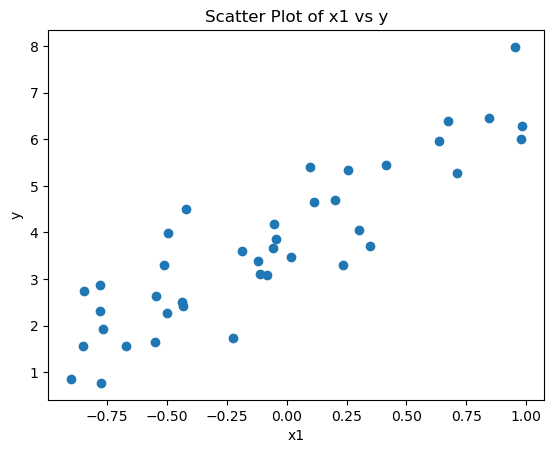

In [89]:
# Set the seed and number of samples
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3 * x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

# Create scatter plot
plt.scatter(x1, y)
plt.xlabel('x1')
plt.ylabel('y')
plt.title('Scatter Plot of x1 vs y')
plt.show()


In [90]:
print(x1.shape)
print(eps.shape)

(40,)
(40,)


## Question 1

In [91]:
x_tensor = torch.tensor(x1, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

theta_0 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
theta_1 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

def model(x):
    return theta_1 * x + theta_0

def mse_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)
if theta_0.grad is not None:
    theta_0.grad.zero_()
if theta_1.grad is not None:
    theta_1.grad.zero_()
y_pred = model(x_tensor)
loss = mse_loss(y_pred, y_tensor)
loss.backward()
true_grad_theta_0 = theta_0.grad.item()
true_grad_theta_1 = theta_1.grad.item()
print(f"Gradient with respect to θ0: {theta_0.grad.item()}")
print(f"Gradient with respect to θ1: {theta_1.grad.item()}")

Gradient with respect to θ0: -7.447054386138916
Gradient with respect to θ1: -1.0253016948699951


## Question 2

In [92]:
stochastic_grad_theta_0 = 0.0
stochastic_grad_theta_1 = 0.0

def mse_loss_single(y_pred, y_true):
    return (y_pred - y_true) ** 2

for i in range(num_samples):
    if theta_0.grad is not None:
        theta_0.grad.zero_()
    if theta_1.grad is not None:
        theta_1.grad.zero_()
    
    y_pred_i = model(x_tensor[i])
    
    loss_i = mse_loss_single(y_pred_i, y_tensor[i])
    
    loss_i.backward()

    stochastic_grad_theta_0 += theta_0.grad.item()
    stochastic_grad_theta_1 += theta_1.grad.item()
avg_stochastic_grad_theta_0 = stochastic_grad_theta_0 / num_samples
avg_stochastic_grad_theta_1 = stochastic_grad_theta_1 / num_samples

print(f"True gradient for θ0: {true_grad_theta_0}, θ1: {true_grad_theta_1}")
print(f"Average stochastic gradient for θ0: {avg_stochastic_grad_theta_0}, θ1: {avg_stochastic_grad_theta_1}")

True gradient for θ0: -7.447054386138916, θ1: -1.0253016948699951
Average stochastic gradient for θ0: -7.4470539569854735, θ1: -1.0253017988055944


## Question 3

In [93]:
def model(x, theta_0, theta_1):
    return theta_1 * x + theta_0

def mse_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

def compute_gradients(x_batch, y_batch, theta_0, theta_1):
    y_pred = model(x_batch, theta_0, theta_1)
    loss = mse_loss(y_pred, y_batch)
    loss.backward()
    return theta_0.grad.item(), theta_1.grad.item(), loss.item()

def plot_contour(theta_0_hist, theta_1_hist, title=""):
    theta_0_vals = np.linspace(-2, 6, 100)
    theta_1_vals = np.linspace(0, 6, 100)
    loss_vals = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            theta_0_grid = torch.tensor(theta_0_vals[i], dtype=torch.float32)
            theta_1_grid = torch.tensor(theta_1_vals[j], dtype=torch.float32)
            y_pred_grid = model(x_tensor, theta_0_grid, theta_1_grid)
            loss_vals[j, i] = mse_loss(y_pred_grid, y_tensor).item()

    plt.contour(theta_0_vals, theta_1_vals, loss_vals, levels=50)
    plt.plot(theta_0_hist, theta_1_hist, 'ro-', label='Optimization Path')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.title(title)
    plt.legend()
    plt.show()


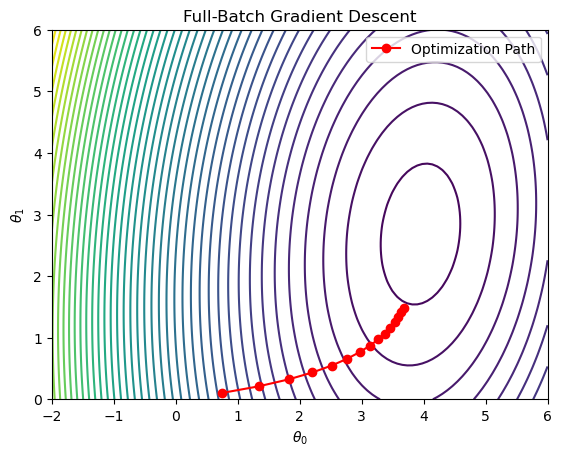

In [184]:
def full_batch_gradient_descent(x, y, lr=0.1, epochs=15, epsilon=0.001):
    theta_0 = torch.tensor(0.0, requires_grad=True)
    theta_1 = torch.tensor(0.0, requires_grad=True)
    theta_0_hist, theta_1_hist, loss_hist = [], [], []
    curr = np.inf
    for epoch in range(epochs):
        if theta_0.grad is not None:
            theta_0.grad.zero_()
        if theta_1.grad is not None:
            theta_1.grad.zero_()

        y_pred = model(x, theta_0, theta_1)
        loss = mse_loss(y_pred, y)
        loss.backward()
        theta_0.data -= lr * theta_0.grad
        theta_1.data -= lr * theta_1.grad
        
        theta_0_hist.append(theta_0.item())
        theta_1_hist.append(theta_1.item())
        loss_hist.append(loss.item())
        if abs(curr - loss.item()) < epsilon:
            print(f"Converged in {epoch+1} epochs")
            break
        curr = loss.item()


    return theta_0_hist, theta_1_hist, loss_hist

theta_0_hist_fb, theta_1_hist_fb, loss_hist_fb = full_batch_gradient_descent(x_tensor, y_tensor)
plot_contour(theta_0_hist_fb, theta_1_hist_fb, title="Full-Batch Gradient Descent")


Converged in 14 epochs


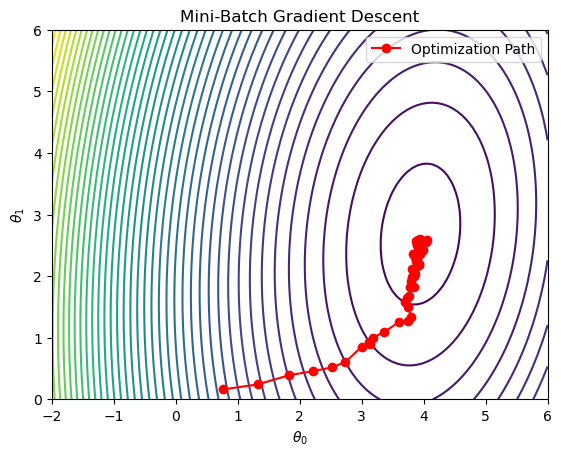

In [183]:
def mini_batch_gradient_descent(x, y, batch_size=10, lr=0.1, epochs=15, epsilon=0.001):
    num_iterations = 0
    theta_0 = torch.tensor(0.0, requires_grad=True)
    theta_1 = torch.tensor(0.0, requires_grad=True)
    theta_0_hist, theta_1_hist, loss_hist = [], [], []

    num_batches = len(x) // batch_size
    curr = np.inf
    for epoch in range(epochs):
        net_loss=0
        perm = torch.randperm(len(x)) 
        for i in range(num_batches):
            if theta_0.grad is not None:
                theta_0.grad.zero_()
            if theta_1.grad is not None:
                theta_1.grad.zero_()

            indices = perm[i*batch_size:(i+1)*batch_size]
            x_batch, y_batch = x[indices], y[indices]
            grad_0, grad_1, loss = compute_gradients(x_batch, y_batch, theta_0, theta_1)

            theta_0.data -= lr * grad_0
            theta_1.data -= lr * grad_1

            theta_0_hist.append(theta_0.item())
            theta_1_hist.append(theta_1.item())
            net_loss+=loss
        net_loss/=num_batches
        loss_hist.append(net_loss)
        if abs(curr - net_loss) < epsilon:
            print(f"Converged in {epoch+1} epochs")
            break
        num_iterations = epoch+1
        curr = net_loss
    return theta_0_hist, theta_1_hist, loss_hist, num_iterations

theta_0_hist_mb, theta_1_hist_mb, loss_hist_mb,num_iterations = mini_batch_gradient_descent(x_tensor, y_tensor)
plot_contour(theta_0_hist_mb, theta_1_hist_mb, title="Mini-Batch Gradient Descent")


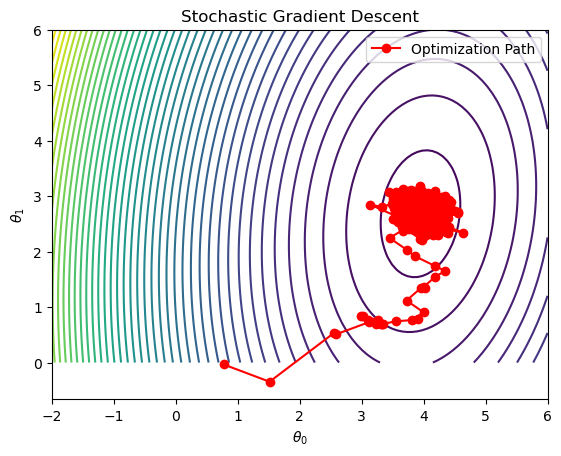

In [182]:
def stochastic_gradient_descent(x, y, lr=0.1, epochs=15, epsilon=0.001):
    theta_0 = torch.tensor(0.0, requires_grad=True)
    theta_1 = torch.tensor(0.0, requires_grad=True)
    theta_0_hist, theta_1_hist, loss_hist = [], [], []
    curr = np.inf
    for epoch in range(epochs):
        perm = torch.randperm(len(x)) 
        net_loss=0
        for i in range(len(x)):
            if theta_0.grad is not None:
                theta_0.grad.zero_()
            if theta_1.grad is not None:
                theta_1.grad.zero_()

            index = perm[i]
            x_single, y_single = x[index], y[index]
            grad_0, grad_1, loss = compute_gradients(x_single, y_single, theta_0, theta_1)

            theta_0.data -= lr * grad_0
            theta_1.data -= lr * grad_1

            theta_0_hist.append(theta_0.item())
            theta_1_hist.append(theta_1.item())
            net_loss+=loss
        net_loss /=len(x)
        loss_hist.append(net_loss)
        if abs(curr - net_loss) < epsilon:
            print(f"Converged in {epoch+1} epochs")
            break
        curr = net_loss
    return theta_0_hist, theta_1_hist, loss_hist, epoch+1

theta_0_hist_sgd, theta_1_hist_sgd, loss_hist_sgd, num_iterations = stochastic_gradient_descent(x_tensor, y_tensor)
plot_contour(theta_0_hist_sgd, theta_1_hist_sgd, title="Stochastic Gradient Descent")



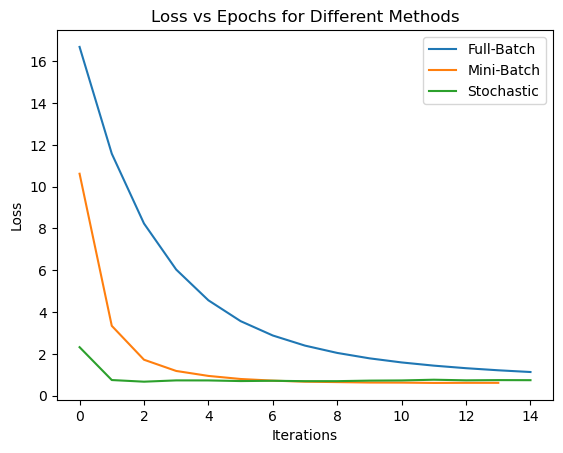

In [185]:
plt.plot(loss_hist_fb, label='Full-Batch')
plt.plot(loss_hist_mb, label='Mini-Batch')
plt.plot(loss_hist_sgd, label='Stochastic')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs for Different Methods')
plt.show()


In [179]:
mini_iter = 0
for i in range(50):
    theta_0_hist_mb, theta_1_hist_mb, loss_hist_mb,num_iterations = mini_batch_gradient_descent(x_tensor, y_tensor,epochs=1000)
    mini_iter+=num_iterations
mini_iter/=50
print(mini_iter)

Converged in 17 epochs
Converged in 11 epochs
Converged in 19 epochs
Converged in 20 epochs
Converged in 18 epochs
Converged in 9 epochs
Converged in 27 epochs
Converged in 9 epochs
Converged in 17 epochs
Converged in 24 epochs
Converged in 33 epochs
Converged in 13 epochs
Converged in 17 epochs
Converged in 19 epochs
Converged in 37 epochs
Converged in 16 epochs
Converged in 33 epochs
Converged in 17 epochs
Converged in 21 epochs
Converged in 18 epochs
Converged in 17 epochs
Converged in 37 epochs
Converged in 14 epochs
Converged in 15 epochs
Converged in 32 epochs
Converged in 18 epochs
Converged in 19 epochs
Converged in 23 epochs
Converged in 26 epochs
Converged in 20 epochs
Converged in 18 epochs
Converged in 44 epochs
Converged in 27 epochs
Converged in 11 epochs
Converged in 18 epochs
Converged in 28 epochs
Converged in 11 epochs
Converged in 14 epochs
Converged in 12 epochs
Converged in 15 epochs
Converged in 25 epochs
Converged in 30 epochs
Converged in 21 epochs
Converged in 

In [180]:
st_iter = 0
for i in range(50):
    theta_0_hist_sgd, theta_1_hist_sgd, loss_hist_sgd, num_iterations = stochastic_gradient_descent(x_tensor, y_tensor,epochs=1000)
    st_iter+=num_iterations
st_iter/=50
print(mini_iter)

Converged in 58 epochs
Converged in 196 epochs
Converged in 75 epochs
Converged in 18 epochs
Converged in 154 epochs
Converged in 28 epochs
Converged in 66 epochs
Converged in 149 epochs
Converged in 101 epochs
Converged in 49 epochs
Converged in 52 epochs
Converged in 198 epochs
Converged in 26 epochs
Converged in 3 epochs
Converged in 48 epochs
Converged in 23 epochs
Converged in 11 epochs
Converged in 116 epochs
Converged in 80 epochs
Converged in 76 epochs
Converged in 18 epochs
Converged in 199 epochs
Converged in 18 epochs
Converged in 114 epochs
Converged in 46 epochs
Converged in 40 epochs
Converged in 11 epochs
Converged in 66 epochs
Converged in 8 epochs
Converged in 90 epochs
Converged in 30 epochs
Converged in 53 epochs
Converged in 5 epochs
Converged in 228 epochs
Converged in 28 epochs
Converged in 122 epochs
Converged in 45 epochs
Converged in 131 epochs
Converged in 22 epochs
Converged in 82 epochs
Converged in 27 epochs
Converged in 27 epochs
Converged in 70 epochs
Con

Q) Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution,
A) 49 iterations for full batch
   20 iterations for mini-batch on an average
   20 iteraions for stochastic gradient descent on an average

In general, **stochastic gradient descent (SGD)** tends to converge faster than **vanilla gradient descent** for large datasets. This is because SGD updates the model parameters more frequently, using a single data point or a small batch of data points at each iteration, which can lead to faster convergence.

On the other hand, vanilla gradient descent computes the gradient using the entire dataset at each iteration, which can be computationally expensive for large datasets and may require more epochs to converge.

However, the convergence behavior can also depend on the specific characteristics of the dataset and the optimization problem. For some datasets, vanilla gradient descent may converge faster due to its more stable updates, while SGD may struggle with noisy or sparse data.

## Question 4

In [186]:
def plot_vectors(theta_0_hist, theta_1_hist, gradients, momenta, title=""):
    plt.figure(figsize=(8, 6))
    
    theta_0_vals = np.linspace(-2, 6, 100)
    theta_1_vals = np.linspace(0, 6, 100)
    loss_vals = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            theta_0_grid = torch.tensor(theta_0_vals[i], dtype=torch.float32)
            theta_1_grid = torch.tensor(theta_1_vals[j], dtype=torch.float32)
            y_pred_grid = model(x_tensor, theta_0_grid, theta_1_grid)
            loss_vals[j, i] = mse_loss(y_pred_grid, y_tensor).item()

    plt.contour(theta_0_vals, theta_1_vals, loss_vals, levels=50)

    plt.plot(theta_0_hist, theta_1_hist, 'ro-', label='Optimization Path')

    for i in range(len(gradients)):
        theta = np.array([theta_0_hist[i], theta_1_hist[i]])
        grad = np.array(gradients[i])
        mom = np.array(momenta[i])

        plt.quiver(theta[0], theta[1], grad[0], grad[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Gradient' if i == 0 else "")
        plt.quiver(theta[0], theta[1], mom[0], mom[1], angles='xy', scale_units='xy', scale=1, color='green', label='Momentum' if i == 0 else "")

    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.legend()
    plt.title(title)
    plt.show()


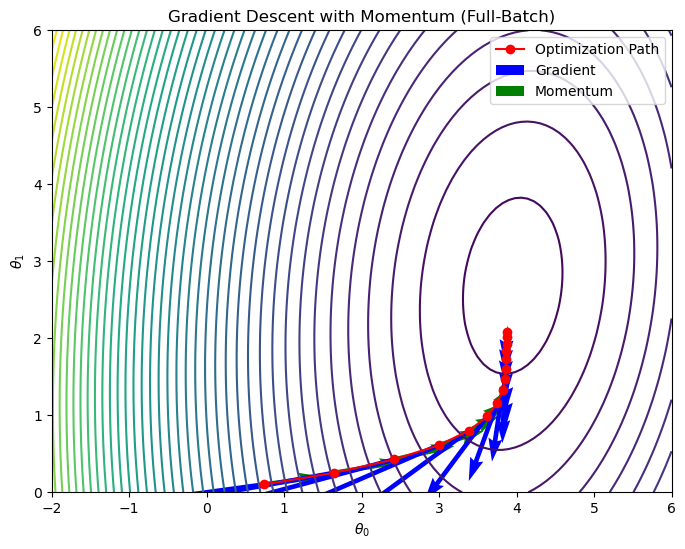

In [196]:
def gradient_descent_with_momentum(x, y, lr=0.1, beta=0.4, epochs=15, epsilon=0.001):
    theta_0 = torch.tensor(0.0, requires_grad=True)
    theta_1 = torch.tensor(0.0, requires_grad=True)
    v_0, v_1 = 0.0, 0.0 
    
    theta_0_hist, theta_1_hist, loss_hist = [], [], []
    gradients, momenta = [], []
    prev_loss = np.inf
    for epoch in range(epochs):
        if theta_0.grad is not None:
            theta_0.grad.zero_()
        if theta_1.grad is not None:
            theta_1.grad.zero_()

        y_pred = model(x, theta_0, theta_1)
        loss = mse_loss(y_pred, y)
        loss.backward()
        
        grad_0, grad_1 = theta_0.grad.item(), theta_1.grad.item()

        v_0 = beta * v_0 - lr * grad_0
        v_1 = beta * v_1 - lr * grad_1

        theta_0.data += v_0
        theta_1.data += v_1
        
        theta_0_hist.append(theta_0.item())
        theta_1_hist.append(theta_1.item())
        gradients.append([grad_0, grad_1])
        momenta.append([v_0, v_1])
        loss_hist.append(loss.item())
        
        if abs(prev_loss - loss.item()) < epsilon:
            print(f"Converged in {epoch+1} epochs")
            break
        prev_loss = loss.item()

    return theta_0_hist, theta_1_hist, loss_hist, gradients, momenta

theta_0_hist_mom, theta_1_hist_mom, loss_hist_mom, gradients_mom, momenta_mom = gradient_descent_with_momentum(x_tensor, y_tensor)

plot_vectors(theta_0_hist_mom, theta_1_hist_mom, gradients_mom, momenta_mom, title="Gradient Descent with Momentum (Full-Batch)")


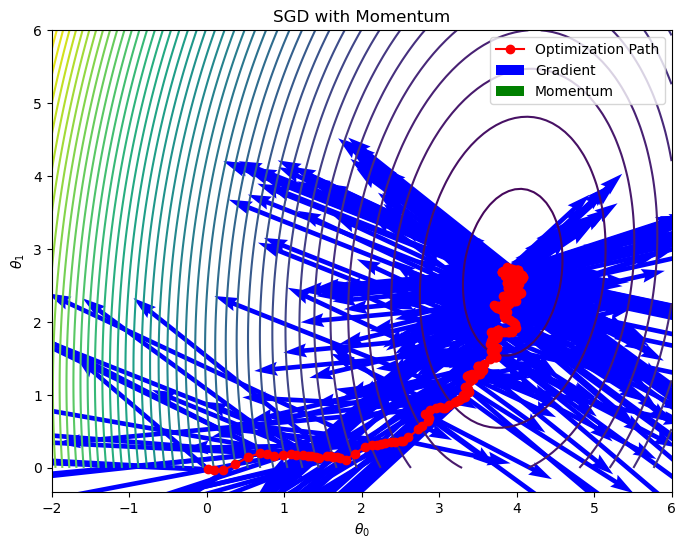

In [198]:
def stochastic_gd_with_momentum(x, y, lr=0.01, beta=0.4, epochs=15, epsilon=0.001):
    theta_0 = torch.tensor(0.0, requires_grad=True)
    theta_1 = torch.tensor(0.0, requires_grad=True)
    v_0, v_1 = 0.0, 0.0
    
    theta_0_hist, theta_1_hist, loss_hist = [], [], []
    gradients, momenta = [], []
    curr = np.inf
    for epoch in range(epochs):
        net_loss = 0
        perm = torch.randperm(len(x))  
        for i in range(len(x)):
            if theta_0.grad is not None:
                theta_0.grad.zero_()
            if theta_1.grad is not None:
                theta_1.grad.zero_()

            index = perm[i]
            x_single, y_single = x[index], y[index]

            grad_0, grad_1, loss = compute_gradients(x_single, y_single, theta_0, theta_1)

            v_0 = beta * v_0 - lr * grad_0
            v_1 = beta * v_1 - lr * grad_1

            theta_0.data += v_0
            theta_1.data += v_1

            theta_0_hist.append(theta_0.item())
            theta_1_hist.append(theta_1.item())
            gradients.append([grad_0, grad_1])
            momenta.append([v_0, v_1])
            net_loss+=loss
        net_loss/=len(x)
        loss_hist.append(net_loss)
        if abs(net_loss - curr) < epsilon:
            print(f"Converged in {epoch+1} epochs")
            break
        curr = net_loss
    return theta_0_hist, theta_1_hist, loss_hist, gradients, momenta,epoch+1

theta_0_hist_sgd_mom, theta_1_hist_sgd_mom, loss_hist_sgd_mom, gradients_sgd_mom, momenta_sgd_mom,num_iterations = stochastic_gd_with_momentum(x_tensor, y_tensor)

plot_vectors(theta_0_hist_sgd_mom, theta_1_hist_sgd_mom, gradients_sgd_mom, momenta_sgd_mom, title="SGD with Momentum")


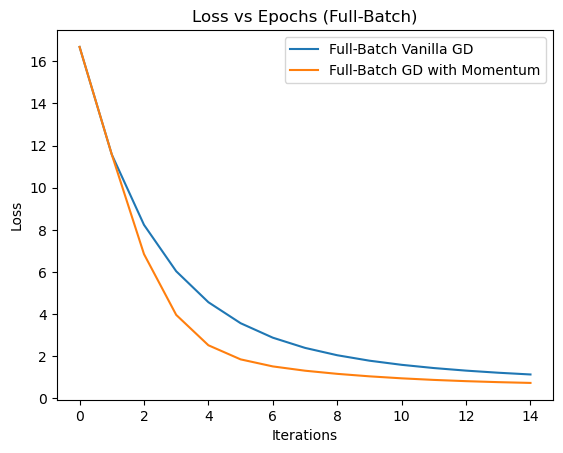

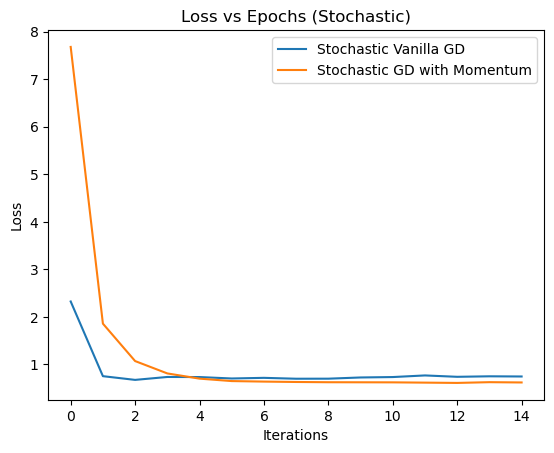

In [190]:
plt.plot(loss_hist_fb, label='Full-Batch Vanilla GD')
plt.plot(loss_hist_mom, label='Full-Batch GD with Momentum')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs (Full-Batch)')
plt.show()

plt.plot(loss_hist_sgd, label='Stochastic Vanilla GD')
plt.plot(loss_hist_sgd_mom, label='Stochastic GD with Momentum')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs (Stochastic)')
plt.show()


In [199]:
st_iter=0
for i in range(50):
    theta_0_hist_sgd_mom, theta_1_hist_sgd_mom, loss_hist_sgd_mom, gradients_sgd_mom, momenta_sgd_mom,num_iterations = stochastic_gd_with_momentum(x_tensor, y_tensor,epochs=1000)
    st_iter+=num_iterations
st_iter/=50
print(st_iter)

Converged in 11 epochs
Converged in 18 epochs
Converged in 9 epochs
Converged in 16 epochs
Converged in 10 epochs
Converged in 8 epochs
Converged in 19 epochs
Converged in 16 epochs
Converged in 25 epochs
Converged in 17 epochs
Converged in 9 epochs
Converged in 27 epochs
Converged in 13 epochs
Converged in 11 epochs
Converged in 17 epochs
Converged in 29 epochs
Converged in 10 epochs
Converged in 17 epochs
Converged in 17 epochs
Converged in 16 epochs
Converged in 15 epochs
Converged in 13 epochs
Converged in 17 epochs
Converged in 15 epochs
Converged in 8 epochs
Converged in 12 epochs
Converged in 12 epochs
Converged in 21 epochs
Converged in 11 epochs
Converged in 15 epochs
Converged in 9 epochs
Converged in 16 epochs
Converged in 11 epochs
Converged in 18 epochs
Converged in 12 epochs
Converged in 12 epochs
Converged in 10 epochs
Converged in 47 epochs
Converged in 9 epochs
Converged in 9 epochs
Converged in 10 epochs
Converged in 14 epochs
Converged in 10 epochs
Converged in 11 ep

Vanilla gradient descent with momentum convergerd in 31 iterations.
Full-batch gradient descent without momentum converged in 49 iterations.
stochastic gradient descent with momentum converged in 14 iterations on an average.
stochastic gradient descent without momnetum converged in 20 iteration on an average.
Observations:
Reducing Oscillations: It smooths the path, preventing back-and-forth movements, especially in steep or curved regions of the loss function.
Accelerating in Consistent Directions: It accumulates past gradients, reinforcing movement in directions where the loss is consistently decreasing.
Maintaining Speed in Flat Regions: It allows the model to keep moving quickly even when current gradients are small, helping avoid slowdowns near the minimum.